# Stationarity Demo

### Imports

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
sns.set(font_scale = 1.2, rc={'figure.figsize':(12,8)})
import warnings
warnings.filterwarnings('ignore')

### Data
Let's use CO2 data (collected by UC Boulder) as it's both highly seasonal and has a notable trend

In [2]:
CO2 = pd.read_csv("../data/stationarity_demo_CO2_data.csv")

### Turn csv time stamps into dates
CO2['Date']=None
for x in range(0,len(CO2)):
    CO2['Date'].iloc[x] = CO2['Start of Week'].iloc[x][:10]

CO2_onedate = CO2.groupby('Date').mean()
CO2_df =  pd.DataFrame(CO2_onedate['CO2 molfrac (ppm)'],index = CO2_onedate.index,columns = ['CO2 molfrac (ppm)'])

### Use data from 2000 onwards
CO2_df = CO2_df.loc['1990':]

### Change to monthly frequency, need a fixed frequency to analyze seasonal patterns
CO2_df.index = pd.to_datetime(CO2_df.index)
CO2_data = CO2_df.resample('M').last()

CO2_data.head()

,CO2 molfrac (ppm)
Date,
1990-01-31,355.295000
1990-02-28,357.260000
1990-03-31,357.016667
1990-04-30,358.233333
1990-05-31,358.318000


**We can clearly see both seasonality and an upwards trend over time below:**

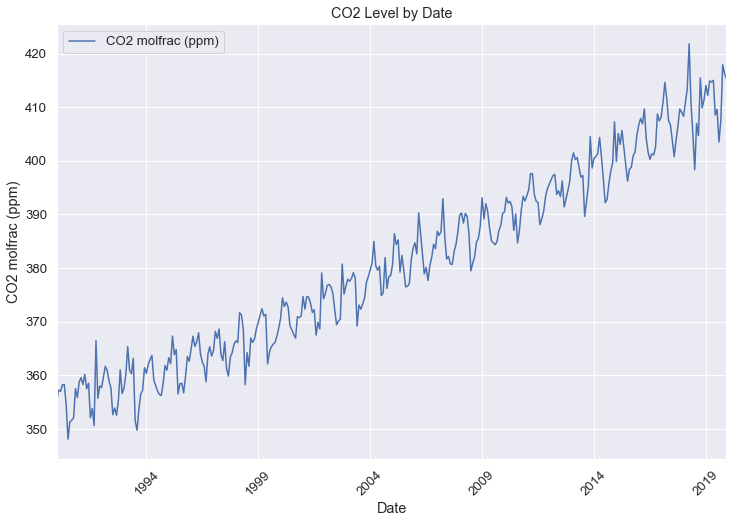

In [3]:
CO2_data.plot()

plt.title('CO2 Level by Date')
plt.ylabel('CO2 molfrac (ppm)')
plt.xlabel('Date')
plt.xticks(rotation = 45)

plt.show()

### Seasonality: 
We can use the statsmodels package to seasonally decompose a timeseries. Below the seasonal impact on CO2 is plotted.

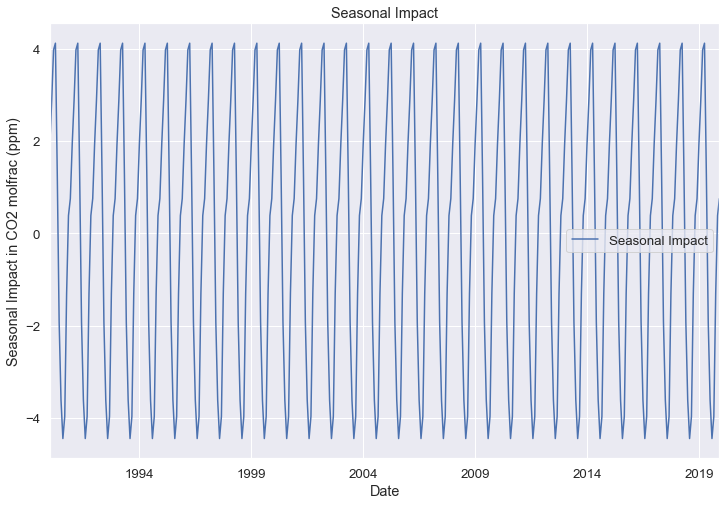

In [4]:
res = sm.tsa.seasonal_decompose(CO2_data.interpolate())
seasonal = res.seasonal.dropna().to_frame(name = 'Seasonal Impact')
seasonal.plot()
plt.title('Seasonal Impact')
plt.ylabel('Seasonal Impact in CO2 molfrac (ppm)')

plt.show()

In [5]:
seasonal.head()

,Seasonal Impact
Date,
1990-01-31,1.922464
1990-02-28,2.873598
1990-03-31,3.972463
1990-04-30,4.117934
1990-05-31,1.250659


To adjust data for seasonality, simply take the data and subtract the seasonal impact:

In [6]:
CO2_noseasonal = (CO2_data['CO2 molfrac (ppm)'] - seasonal['Seasonal Impact']).to_frame('Seasonal adj CO2')

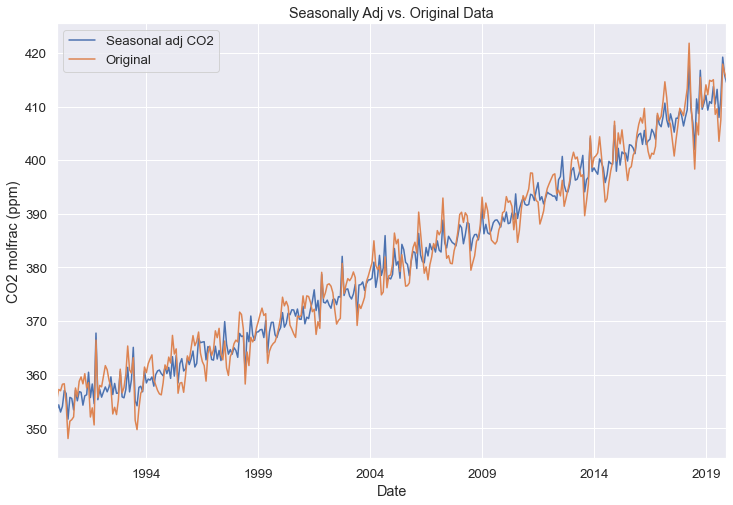

In [7]:
CO2_noseasonal['Original'] = CO2_data['CO2 molfrac (ppm)'] 
CO2_noseasonal.plot()

plt.title('Seasonally Adj vs. Original Data')
plt.ylabel('CO2 molfrac (ppm)')

plt.show()

We have taken out seasonal impact, but still have a strong upwards trend over time. Let's address stationarity now. 

### Stationarity
> - Let's run the Augmented Dickey-Fuller test to determine if the data is stationary
> - Data is stationary if it does not have trend or seasonal effects. The mean and variance of a stationary process do not change over time
> - We want stationary data to avoid spurious results

**Augmented Dickey-Fuller Test**
- Tests the null hypothesis that a unit root is present in a time series
- In other words, if we reject this hypothesis $y_{t-1}$ should not help us predict $y_{t}$ better than $y_{t-k}$ 
- The p-value is the probability that the data is non-stationary. Typically we reject the null at p-value > 0.05
- The more negative the test statistic is, the more likely we are to reject the null

In [8]:
ADFuller_test = adfuller(CO2_noseasonal['Seasonal adj CO2'].values)

print('ADF Test Statistic: ' + str(round(ADFuller_test[0],3)))
print('p-value: ' + str(round(ADFuller_test[1],3)))

ADF Test Statistic: 2.299
p-value: 0.999


The data is very non-stationary, which is easy to tell by looking at the plot.

**Differencing**


We can detrend by differencing:

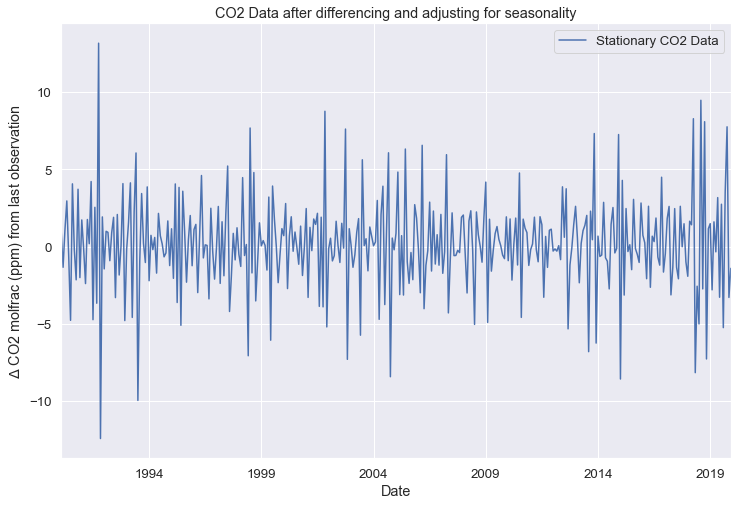

In [9]:
CO2_stationary = CO2_noseasonal['Seasonal adj CO2'].diff().to_frame('Stationary CO2 Data').dropna()

CO2_stationary.plot()
plt.title('CO2 Data after differencing and adjusting for seasonality')
plt.ylabel(r'$\Delta$ CO2 molfrac (ppm) from last observation')

plt.show()

Let's rerun the ADF test now:

In [10]:
ADFuller_test2 = adfuller(CO2_stationary.values)

print('ADF Test Statistic: ' + str(round(ADFuller_test2[0],3)))
print('p-value: ' + str(round(ADFuller_test2[1],3)))

ADF Test Statistic: -10.322
p-value: 0.0
